In [1]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm

In [2]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

from market.heston import HestonModel
from market.heston import make_varianceswap_paths
from payoff.european_option import european_call_payoff
from utils.networks import MultiAssetHedgeModel, RecurrentHedgeModel
from optimizer.hedge_train import DeepHedgeCVaRTrainer2Asset, DeepHedgeCVaRTrainer  # or the approach you prefer

In [3]:
# 1) Simulate
heston = HestonModel(
    s0=100.0,     # initial spot
    v0=0.04,      # initial variance
    kappa=1.5,    # mean reversion speed
    theta=0.04,   # long-term variance (mean reversion level)
    xi=0.5,       # vol-of-vol
    rho=-0.7,     # correlation between Brownian shocks
    r=0.0,        # risk-free rate
    dt=1.0/365.0, # daily time step
    seed=1234     # random seed for reproducibility
)
S_np, V_np = heston.simulate_paths(n_paths=100000, n_steps=30)
vsw_np = make_varianceswap_paths(S_np, V_np, dt=heston.dt)
# shape => (n_paths, n_steps+1)
# stack them to shape => (n_paths, n_steps+1, 2)
market_np = np.stack([S_np, vsw_np], axis=-1)

In [4]:
# 2) Payoff
K=100.0
Z_np = european_call_payoff(S_np, K=K)

# Convert to torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
market_torch = torch.from_numpy(market_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

In [5]:
S_torch = torch.from_numpy(S_np).float().to(device)

alpha = 0.5

num_steps = S_torch.shape[1] - 1

recurrent_model = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

trainer_rec = DeepHedgeCVaRTrainer(
    model=recurrent_model, 
    loss_function="cvar", 
    alpha=alpha
)

p0_rec = trainer_rec.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=0.0,
    n_epochs=5,
    batch_size=4096
)

print(f"Recurrent Hedge Price p0_rec = {p0_rec:.4f}")

# Evaluate model performance (no gradient computation needed)
with torch.no_grad():
    deltas_rec = recurrent_model(S_torch)
    Sdiff = S_torch[:, 1:] - S_torch[:, :-1]  
    gains_rec = torch.sum(deltas_rec * Sdiff, dim=1)
    pnl_rec = (trainer_rec.p0 - Z_torch + gains_rec).cpu().numpy()

Epoch 1/5 | Loss: 91.6114 | p0: 0.0000
Epoch 2/5 | Loss: 15.8674 | p0: 0.0000
Epoch 3/5 | Loss: 4.2079 | p0: 0.0000
Epoch 4/5 | Loss: 3.4742 | p0: 0.0000
Epoch 5/5 | Loss: 3.4892 | p0: 0.0000
Recurrent Hedge Price p0_rec = 0.0000


In [6]:
# 3) Build multi-asset net & train
model_ma = MultiAssetHedgeModel(steps=num_steps, in_dim=4, hidden_dim=32, out_dim=2).to(device)
trainer_ma = DeepHedgeCVaRTrainer2Asset(model_ma, alpha=0.5, lr=1e-3)

p0 = trainer_ma.train(market_torch, Z_torch, p0_init=0.0, n_epochs=5, batch_size=2048)
print("Learned hedge cost p0 =", p0)

# Evaluate final distribution
with torch.no_grad():
    deltas = model_ma(market_torch)
    # compute final PnL
    from optimizer.hedge_train import compute_2instrument_pnl
    pnl_torch = compute_2instrument_pnl(trainer_ma.p0, Z_torch, deltas, market_torch)
pnl_np = pnl_torch.cpu().numpy()

Learned hedge cost p0 = 0.24500036239624023


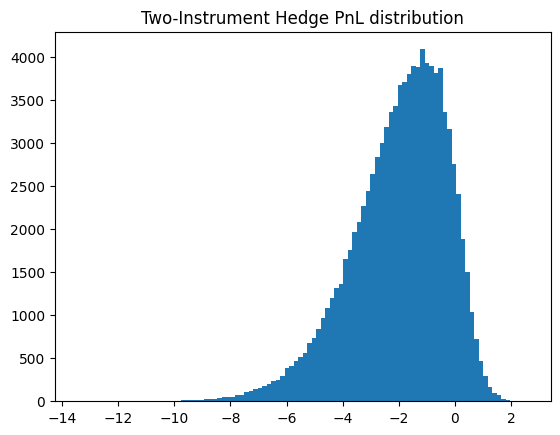

In [7]:
plt.hist(pnl_np, bins=100)
plt.title("Two-Instrument Hedge PnL distribution")
plt.show()

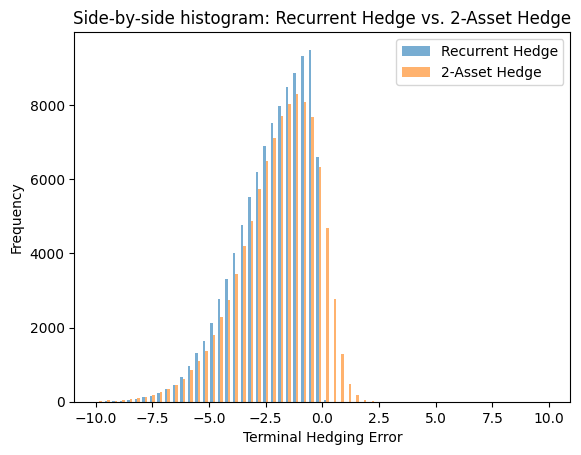

In [8]:
# ----------------------------------------------------------------------------
# 7) Figures
# ----------------------------------------------------------------------------

def plot_side_by_side_hist(pnl1, pnl2, label1="CVaR Hedge", label2="Model Hedge",
                           bins=50, range=(-10,10)):
    """
    Plot side-by-side histogram bars for two PnL arrays, over the same bins.
    
    Args:
      pnl1, pnl2: 1D arrays of data.
      label1, label2: legend labels for the two sets of bars.
      bins: int or sequence of bin edges
      range: (min, max) range for the histogram
    """
    # 1) Manually compute hist counts for each distribution
    counts1, edges = np.histogram(pnl1, bins=bins, range=range)
    counts2, _     = np.histogram(pnl2, bins=edges)  # use same edges for second data
    
    # 2) Convert counts to frequency or density, if desired (optional)
    # e.g. to show frequencies, we can keep as is, or for probability densities:
    # step = edges[1] - edges[0]
    # counts1 = counts1 / (counts1.sum() * step)
    # counts2 = counts2 / (counts2.sum() * step)
    
    # 3) The bin centers
    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0  # bar width is 1/3 of bin width
                                          # so the two bars can fit side by side
    
    # 4) Shift one bar group left, the other right
    plt.bar(
        centers - width/2, counts1, width=width,
        alpha=0.6, label=label1, color='tab:blue'
    )
    plt.bar(
        centers + width/2, counts2, width=width,
        alpha=0.6, label=label2, color='tab:orange'
    )
    
    # 5) Label and show
    plt.xlabel("Terminal Hedging Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Side-by-side histogram: {label1} vs. {label2}")
    plt.show()

plot_side_by_side_hist(pnl_rec, pnl_np,
                       label1="Recurrent Hedge", label2="2-Asset Hedge",
                       bins=60, range=(-10,10))


In [9]:
def compute_cvar(pnl, alpha):
    """
    Computes empirical CVaR at the given alpha level.
    """
    quantile = np.percentile(pnl, 100 * (1 - alpha))
    cvar = pnl[pnl <= quantile].mean()
    return cvar

# Compute Mean Loss
# mean_loss_99 = pnl_rec_99.mean()
# mean_loss_50 = pnl_rec.mean()
mean_loss_rec = pnl_rec.mean()
mean_loss_ma = pnl_np.mean()

# Compute Realized CVaR
# cvar_50_50 = compute_cvar(pnl_rec, alpha=0.50)
# cvar_50_99 = compute_cvar(pnl_rec, alpha=0.99)

# cvar_99_50 = compute_cvar(pnl_rec_99, alpha=0.50)
# cvar_99_99 = compute_cvar(pnl_rec_99, alpha=0.99)

cvar_rec_50 = compute_cvar(pnl_rec, alpha=0.50)
cvar_rec_99 = compute_cvar(pnl_rec, alpha=0.99)

cvar_ma_50 = compute_cvar(pnl_np, alpha=0.50)
cvar_ma_99 = compute_cvar(pnl_np, alpha=0.99)

# Display Results
import pandas as pd
table_data = {
    # "Mean Loss": [mean_loss_99, mean_loss_50],
    # "Realized 50%-CVaR": [cvar_99_50, cvar_50_50],
    # "Realized 99%-CVaR": [cvar_99_99, cvar_50_99]
    "Mean Loss": [mean_loss_rec, mean_loss_ma],
    "50%-CVaR": [cvar_rec_50, cvar_ma_50],
    "99%-CVaR": [cvar_rec_99, cvar_ma_99]
}

df = pd.DataFrame(table_data, index=["Recurrent Hedge", "2-Asset Hedge"])
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Comparison of 99%-CVaR and 50%-CVaR", dataframe=df)

In [10]:
df

,Mean Loss,50%-CVaR,99%-CVaR
Recurrent Hedge,-2.243565,-3.489184,-7.436732
2-Asset Hedge,-2.000017,-3.338693,-7.981175


In [11]:
def simulate_two_instruments(self, n_paths=10000, n_steps=30):
    S, V = self.simulate_paths(n_paths, n_steps)
    dt = (n_steps * self.dt) / n_steps  # or simply self.dt
    vsw = make_varianceswap_paths(S, V, dt)
    return S, V, vsw